In [1]:
import os
import math
import numpy as np
import ffmpeg
import cv2
import imutils
from imutils.video import count_frames
import matplotlib.pyplot as plt
from IPython.display import Audio

In [2]:
ROOT_DIR = os.path.dirname(os.getcwd())
DATA_FOLDER = os.path.join(ROOT_DIR, "data")

In [3]:
video_waltter_path = os.path.join(DATA_FOLDER, "example_waltter_synchronized.mov")
video_vikture_path = os.path.join(DATA_FOLDER, "example_vikture_late_15s_synchronized.mov")

video_keparoicam_L = os.path.join(DATA_FOLDER, "keparoicam_clipL_synchronized.mp4")
video_keparoicam_R = os.path.join(DATA_FOLDER, "keparoicam_clipR_synchronized.mp4")

In [4]:
target_video_L = video_keparoicam_L
target_video_R = video_keparoicam_R

In [5]:
video_left_capture = cv2.VideoCapture(target_video_L)
video_right_capture = cv2.VideoCapture(target_video_R)

In [6]:
video_left_frames = count_frames(target_video_L)
video_right_frames = count_frames(target_video_R)

print(video_left_frames)
print(video_right_frames)

10740
10705


In [7]:
total_frames = 10763
# total_frames = min(video_left_frames, video_right_frames)

In [8]:
left_n_frames = int(video_left_capture.get(cv2.CAP_PROP_FRAME_COUNT))
right_n_frames = int(video_right_capture.get(cv2.CAP_PROP_FRAME_COUNT))

print(left_n_frames)
print(right_n_frames)

left_width = int(video_left_capture.get(cv2.CAP_PROP_FRAME_WIDTH)) 
left_height = int(video_left_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
left_fps = video_left_capture.get(cv2.CAP_PROP_FPS)

right_width = int(video_right_capture.get(cv2.CAP_PROP_FRAME_WIDTH)) 
right_height = int(video_right_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
right_fps = video_right_capture.get(cv2.CAP_PROP_FPS)

print(left_width)
print(left_height)
print(left_fps)

print(right_width)
print(right_height)
print(right_fps)

10774
10763
1920
1080
59.94005994005994
1920
1080
59.9365495637156


In [11]:
final_fps = 60.0
final_height = 1080
final_width = 1920*2

In [12]:
stitcher = cv2.Stitcher_create(cv2.Stitcher_PANORAMA)

In [13]:
video_path = os.path.join(DATA_FOLDER, "keparoicam_panorama.mp4")
video_output = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*"H264"),final_fps,(final_width,final_height))

OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'
[ERROR:0@197.229] global cap_ffmpeg_impl.hpp:2991 open Could not find encoder for codec_id=27, error: Encoder not found
[ERROR:0@197.229] global cap_ffmpeg_impl.hpp:3066 open VIDEOIO/FFMPEG: Failed to initialize VideoWriter


In [14]:
def equalize_histogram(rgb_image):
    r_image, g_image, b_image = cv2.split(rgb_image)

    r_image_eq = cv2.equalizeHist(r_image)
    g_image_eq = cv2.equalizeHist(g_image)
    b_image_eq = cv2.equalizeHist(b_image)

    image_eq = cv2.merge([r_image_eq, g_image_eq, b_image_eq])
    return image_eq

In [15]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

def apply_clahe(image):
    image_lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    image_lab[...,0] = clahe.apply(image_lab[...,0])

    bgr_clahe_image = cv2.cvtColor(image_lab, cv2.COLOR_LAB2BGR)
    rgb_clahe_image = cv2.cvtColor(bgr_clahe_image, cv2.COLOR_BGR2RGB)

    return rgb_clahe_image

In [17]:
def apply_sift(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    (kps, features) = sift.detectAndCompute(image, None)
    kps = np.float32([kp.pt for kp in kps])
    return (kps, features)

def match_keypoints_and_homography(keypoints1, keypoints2, features1, features2, ratio, reprojection_thresh):
    matcher = cv2.DescriptorMatcher_create("BruteForce")
    raw_matches = matcher.knnMatch(features1, features2, 2)
    matches = []
    
    for match in raw_matches:
        if len(match) == 2 and match[0].distance < match[1].distance * ratio:
            matches.append((match[0].trainIdx, match[0].queryIdx))
            
    # computing a homography requires at least 4 matches
    if len(matches) < 4:
        return None
    else:
        # construct the two sets of points
        points1 = np.float32([keypoints1[i] for (_, i) in matches])
        points2 = np.float32([keypoints2[i] for (i, _) in matches])
        # compute the homography between the two sets of points
        (H, status) = cv2.findHomography(points1, points2, cv2.RANSAC, reprojection_thresh)
        # return the matches along with the homograpy matrix
        # and status of each matched point
        return (matches, H, status)
    

def draw_matches(image1, image2, keypoints1, keypoints2, matches, status):
    (hA, wA) = image1.shape[:2]
    (hB, wB) = image2.shape[:2]
    vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
    vis[0:hA, 0:wA] = image1
    vis[0:hB, wA:] = image2
    
    for ((trainIdx, queryIdx), s) in zip(matches, status):
        if s == 1:
            points1 = (int(keypoints1[queryIdx][0]), int(keypoints1[queryIdx][1]))
            points2 = (int(keypoints2[trainIdx][0]) + wA, int(keypoints2[trainIdx][1]))
            cv2.line(vis, points1, points2, (0, 255, 0), 1)
    # return the visualization
    return vis

def stitch(image1, image2, ratio=0.75, reprojection_thresh=4.0):
    
    image2, image1 = image1, image2
    
    keypoints1, features1 = apply_sift(image1)
    keypoints2, features2 = apply_sift(image2)
    
    M = match_keypoints_and_homography(keypoints1, keypoints2, features1, features2, ratio, reprojection_thresh)
    
    (matches, H, status) = M

    if M is None:
        return None
    
    result = cv2.warpPerspective(image1, M[1],
        (image1.shape[1] + image2.shape[1], image1.shape[0]))
    
    result[0:image2.shape[0], 0:image2.shape[1]] = image2
    
    #vis = draw_matches(image1, image2, keypoints1, keypoints2, matches, status)
    #plt.imshow(vis)
    #plt.show()
    
    return result

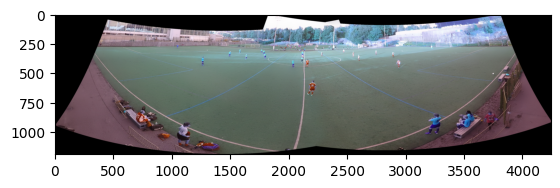

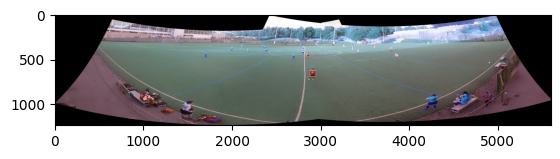

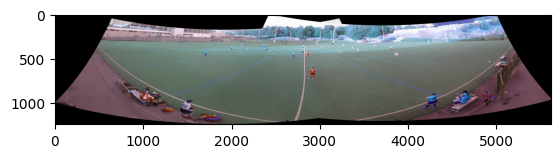

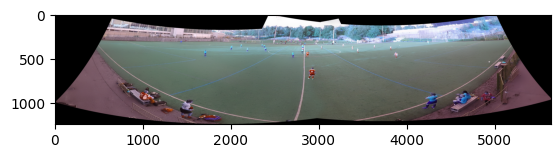

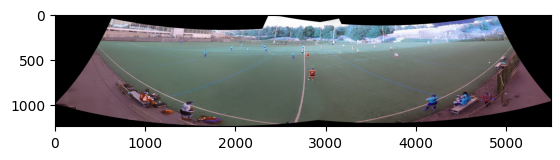

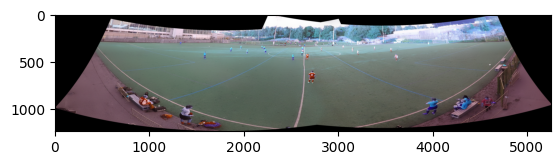

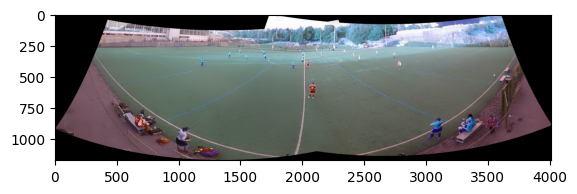

KeyboardInterrupt: 

In [20]:
#stitcher.setPanoConfidenceThresh(1.0)
#stitcher.setRegistrationResol(0.5); 
#stitcher.setSeamEstimationResol(0.1);
#stitcher.setCompositingResol(1);  
#stitcher.setWaveCorrection(True);

def rgb_to_gray(rgb_image: np.ndarray):
    return np.dot(rgb_image[...,:3], [0.2989, 0.5870, 0.1140])

#video_left_capture.set(cv2.CAP_PROP_POS_FRAMES, 0)
#video_right_capture.set(cv2.CAP_PROP_POS_FRAMES, 0)

def preprocess_image(image):
    #image = equalize_histogram(image)
    #image = apply_clahe(image)
    
    return image


def get_left_mask(image):
    
    height = image.shape[0]
    width = image.shape[1]
    
    zeros = np.zeros((height, math.ceil(width/3)*2))
    ones = np.ones((height, math.floor(width/3)))
        
    mask = np.hstack((zeros,ones))
    
    return mask
    
    
def get_right_mask(image):
    
    height = image.shape[0]
    width = image.shape[1]
    
    zeros = np.zeros((height, math.ceil(width/3)*2))
    ones = np.ones((height, math.floor(width/3)))
        
    mask = np.hstack((ones, zeros))
    
    return mask

captured_frames = []

for i in range(total_frames):
    left_frame = video_left_capture.read()
    right_frame = video_right_capture.read()
    
    left_image = left_frame[1]
    right_image = right_frame[1]
    
    left_image_processed = left_image
    right_image_processed = right_image
    #left_image_processed = preprocess_image(left_image)
    #right_image_processed = preprocess_image(right_image)
    
    #left_mask = get_left_mask(left_image_processed)
    #right_mask = get_right_mask(right_image_processed)
        
    #(status, stitched) = stitcher.stitch(images=[left_image_processed, right_image_processed], masks=[left_mask, right_mask])
    (status, stitched) = stitcher.stitch(images=[left_image_processed, right_image_processed])

    #stitched = stitch(left_image_clahe, right_image_clahe)
    #status = 0 if stitched is not None else 1

    if status != 0:
        print(f"Image stitching failed: {status}")
        continue
        
    if status == 0:
        plt.imshow(stitched)
        plt.show()
        captured_frames.append(stitched)
    

In [18]:
orb = cv2.ORB_create(nfeatures=2000)

def orb_detect(image1, image2):
    keypoints1, descriptors1 = orb.detectAndCompute(image1, None)
    keypoints2, descriptors2 = orb.detectAndCompute(image2, None)
    
    return (keypoints1, descriptors1, keypoints2, descriptors2)
    
    
def match_keypoints(descriptors1, descriptors2):
    bf = cv2.BFMatcher_create(cv2.NORM_HAMMING)
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)
    return matches
    
def draw_matches_2(image1, keypoints1, image2, keypoints2, matches):
    r1, c1 = image1.shape[:2]
    r2, c2 = image2.shape[:2]

    color_channels = image1.shape[2]
    
    # Create a blank image with the size of the first image + second image
    output_img = np.zeros((max([r1, r2]), c1 + c2, 3), dtype='uint8')
    
    if color_channels == 3:
        output_img[:r1, :c1, :] = np.dstack([image1])
        output_img[:r2, c1:c1+c2, :] = np.dstack([image2])
    else:
        output_img[:r1, :c1, :] = np.dstack([image1, image1, image1])
        output_img[:r2, c1:c1+c2, :] = np.dstack([image2, image2, image2])
        
    # Go over all of the matching points and extract them
    for match in matches:
        img1_idx = match.queryIdx
        img2_idx = match.trainIdx
        (x1, y1) = keypoints1[img1_idx].pt
        (x2, y2) = keypoints2[img2_idx].pt

        # Draw circles on the keypoints
        cv2.circle(output_img, (int(x1),int(y1)), 4, (0, 255, 255), 1)
        cv2.circle(output_img, (int(x2)+c1,int(y2)), 4, (0, 255, 255), 1)

        # Connect the same keypoints
        cv2.line(output_img, (int(x1),int(y1)), (int(x2)+c1,int(y2)), (0, 255, 255), 1)

    return output_img
  
    
def warp_images(image1, image2, H):

    rows1, cols1 = image1.shape[:2]
    rows2, cols2 = image2.shape[:2]

    list_of_points_1 = np.float32([[0,0], [0, rows1],[cols1, rows1], [cols1, 0]]).reshape(-1, 1, 2)
    temp_points = np.float32([[0,0], [0,rows2], [cols2,rows2], [cols2,0]]).reshape(-1,1,2)

    list_of_points_2 = cv2.perspectiveTransform(temp_points, H)
    list_of_points = np.concatenate((list_of_points_1,list_of_points_2), axis=0)

    [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)

    translation_dist = [-x_min,-y_min]

    H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])

    output_img = cv2.warpPerspective(image2, H_translation.dot(H), (x_max-x_min, y_max-y_min))
    output_img[translation_dist[1]:rows1+translation_dist[1], translation_dist[0]:cols1+translation_dist[0]] = image1

    return output_img
    
def stitch_images(image1, image2):
    
    (keypoints1, descriptors1, keypoints2, descriptors2) = orb_detect(image1, image2)
    
    matches = match_keypoints(descriptors1, descriptors2)
    
    # Finding the best matches
    best_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            best_matches.append(m)
                
    #image_matched = draw_matches_2(image1, keypoints1, image2, keypoints2, best_matches[:30])
    #plt.imshow(image_matched)
    #plt.show()
            
    # Set minimum match condition
    MIN_MATCH_COUNT = 5

    if len(best_matches) > MIN_MATCH_COUNT:
        # Convert keypoints to an argument for findHomography
        src_pts = np.float32([ keypoints1[m.queryIdx].pt for m in best_matches]).reshape(-1,1,2)
        dst_pts = np.float32([ keypoints2[m.trainIdx].pt for m in best_matches]).reshape(-1,1,2)

        # Establish a homography
        M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)

        result = warp_images(image2, image1, M)

        return result
    
    return None
    

In [ ]:
def rgb_to_gray(rgb_image: np.ndarray):
    return np.dot(rgb_image[...,:3], [0.2989, 0.5870, 0.1140])


for i in range(total_frames):
    left_frame = video_left_capture.read()
    right_frame = video_right_capture.read()
    
    left_image = left_frame[1]
    right_image = right_frame[1]
    
    #left_image_equalized = equalize_histogram(left_image)
    #right_image_equalized = equalize_histogram(right_image)
    
    #left_image_clahe = apply_clahe(left_image_equalized)
    #right_image_clahe = apply_clahe(right_image_equalized)
    
    #plt.imshow(left_image_clahe)
    #plt.show()
    #plt.imshow(right_image_clahe)
    #plt.show()
    
    left_image_bw = cv2.cvtColor(left_image, cv2.COLOR_RGB2GRAY)
    right_image_bw = cv2.cvtColor(right_image, cv2.COLOR_RGB2GRAY)

    stitched = stitch_images(left_image, right_image)
    
    status = 0 if stitched is not None else 1

    if status != 0:
        print(f"Image stitching failed: {status}")
        break
        
    if status == 0:
        plt.imshow(stitched)
        plt.show()
    

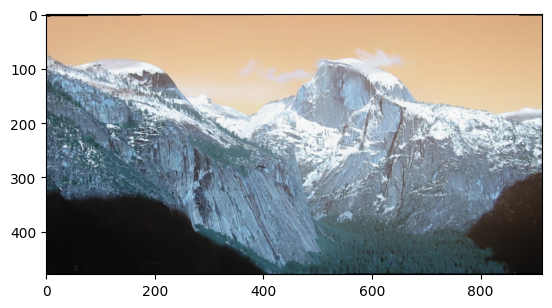

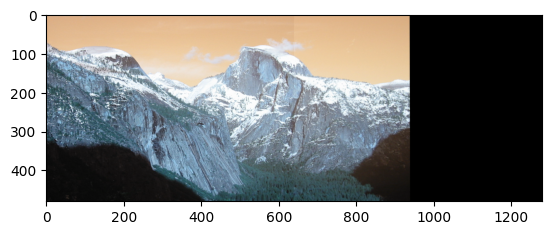

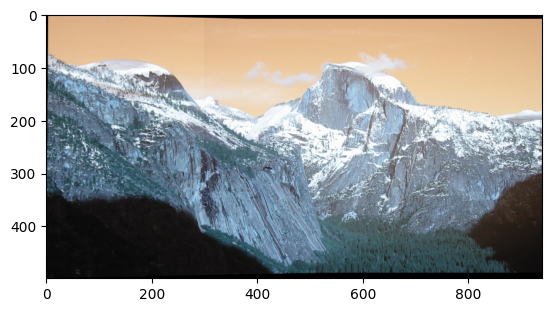

In [19]:
image1 = cv2.imread(os.path.join(DATA_FOLDER, "yosemite1.jpg"))
image2 = cv2.imread(os.path.join(DATA_FOLDER, "yosemite2.jpg"))

# OpenCV method

(status, stitched) = stitcher.stitch(images=[image1, image2])

if status == 0:
    plt.imshow(stitched)
    plt.show()
else:
    print(f"OpenCV method: *Stitching failed: {status}")


# Custom method 1
    
stitched2 = stitch(image1, image2)
    
status2 = 0 if stitched2 is not None else 1

if status2 != 0:
    print(f"Custom 1: Image stitching failed: {status2}")
else:
    plt.imshow(stitched2)
    plt.show()


# Custom method 2

stitched3 = stitch_images(image1, image2)

status3 = 0 if stitched3 is not None else 1

if status3 != 0:
    print(f"Custom 2: Image stitching failed: {status3}")
else:
    plt.imshow(stitched3)
    plt.show()
    



In [ ]:
left_frame = video_left_capture.read()
right_frame = video_right_capture.read()

left_image = left_frame[1]
right_image = right_frame[1]

left_image_path = os.path.join(DATA_FOLDER, "video_left_capture.png")
right_image_path = os.path.join(DATA_FOLDER, "video_right_capture.png")

cv2.imwrite(left_image_path, left_image)
cv2.imwrite(right_image_path, right_image)